<a href="https://colab.research.google.com/github/dimsparagis0210/DFU-using-Deep-Learning/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faster-RCNN Model Development

#### The goal of this BSc thesis is to develop a Deep Learning model for Object Detection. Specifically, the object of the model will be to detect ulcers in Diabetic Foots (DFU)

## Getting Dataset from Google drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# Define dataset path (adjust if needed)
dataset = '/content/drive/MyDrive/DFU_Data_Faster_RCNN'
trainset = dataset + '/images/train'
testset = dataset + '/images/test'
validset = dataset + '/images/valid'

# List categories (folders)
os.listdir('/content/drive/MyDrive')

['Colab Notebooks',
 'ML',
 'Machine Learning A-Z (Model Selection)',
 'Deep Learning',
 'ML_task',
 'Screencastify',
 'DFU',
 'IoT, Big Data, AI Smart Farms.gdoc',
 'Conceptual Analysis of the Study on Environmentally Sustainable Smart Cities.gdoc',
 'DFU_Data',
 'Stergiou CV (1).gdoc',
 'DFU_Data_Tensorflow',
 'Ενοποιημένες',
 'DFU_Data_Faster_RCNN',
 'SSD (1).ipynb',
 'Faster-RCNN.ipynb',
 'SSD.ipynb']

In [ ]:
pip install ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 MB 34.2 MB/s eta 0:00:00


In [52]:
import os
import torch
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torchvision.datasets import CocoDetection
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Data Pipeline

In [4]:
import json

# Load the annotation file
with open('/content/drive/MyDrive/DFU_Data_Faster_RCNN/annotations/train.coco.json') as f:
    data = json.load(f)

# Extract category IDs and names
categories = data.get('categories', [])
num_classes = len(categories)
class_names = [category['name'] for category in categories]

print(f"Number of classes: {num_classes}")
print("Class names:", class_names)
len(class_names)

Number of classes: 2
Class names: ['objects', 'Ulcer']


2

In [58]:
class UlcerDataset(Dataset):
    def __init__(self, img_dir, ann_file, transforms=None):
        self.dataset = CocoDetection(img_dir, ann_file)
        self.transforms = transforms

    def __getitem__(self, idx):
      img, target = self.dataset[idx]
      img_id = self.dataset.ids[idx]

      # Convert image to NumPy
      img = np.array(img).astype(np.uint8)

      boxes = []
      labels = []

      # Check if target has annotations
      if len(target) == 0:
          # Add a dummy box to prevent errors
          boxes = torch.tensor([[0, 0, 1, 1]], dtype=torch.float32)
          labels = torch.tensor([0], dtype=torch.int64)  # Background class
      else:
          for obj in target:
              if "bbox" not in obj:
                  continue

              bbox = obj["bbox"]  # COCO format: [x, y, width, height]
              x, y, w, h = bbox
              boxes.append([x, y, x + w, y + h])  # Convert to Pascal VOC format
              labels.append(obj["category_id"])

          boxes = torch.tensor(boxes, dtype=torch.float32)
          labels = torch.tensor(labels, dtype=torch.int64)

      # Apply augmentations
      if self.transforms:
          transformed = self.transforms(image=img, bboxes=boxes.tolist(), labels=labels.tolist())
          img = transformed["image"]
          boxes = torch.tensor(transformed["bboxes"], dtype=torch.float32)

      target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([img_id])}

      return img, target


    def __len__(self):
        return len(self.dataset)


In [59]:
dataset = UlcerDataset(trainset, os.path.join('/content/drive/MyDrive/DFU_Data_Faster_RCNN', 'annotations', 'train.coco.json'), transforms=None)
dataset.__len__()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


285

## Data Preprocessing

### Data Augmentation & Normalization

In [60]:
def get_transforms(train):
  if train:
    return A.Compose([
        A.Resize(512, 512),
        A.HorizontalFlip(p = 0.5),
        A.RandomBrightnessContrast(p = 0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
  else:
    return A.Compose([
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

### Load the dataset and initilize UlcerDataset Objects

In [71]:
from torch.utils.data import DataLoader

# Paths to dataset
data_root = "/content/drive/MyDrive/DFU_Data_Faster_RCNN"
train_img_dir = os.path.join(data_root, "images/train")
valid_img_dir = os.path.join(data_root, "images/valid")
test_img_dir = os.path.join(data_root, "images/test")

train_ann_file = os.path.join(data_root, "annotations/train.coco.json")
valid_ann_file = os.path.join(data_root, "annotations/valid.coco.json")
test_ann_file = os.path.join(data_root, "annotations/test.coco.json")

# Create dataset instances
train_dataset = UlcerDataset(train_img_dir, train_ann_file, transforms=get_transforms(train=True))
valid_dataset = UlcerDataset(valid_img_dir, valid_ann_file, transforms=get_transforms(train=False))
test_dataset = UlcerDataset(test_img_dir, test_ann_file, transforms=get_transforms(train=False))

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Test loading a batch
images, targets = next(iter(train_loader))
print("Batch loaded successfully")
print(f"Image shape: {images[0].shape}")
print(f"Target example: {targets[0]}")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.95s)
creating index...
index created!
Batch loaded successfully
Image shape: torch.Size([3, 512, 512])
Target example: {'boxes': tensor([[147.6000,  81.6000, 379.2000, 172.0000]]), 'labels': tensor([1]), 'image_id': tensor([231])}


### Visualizations

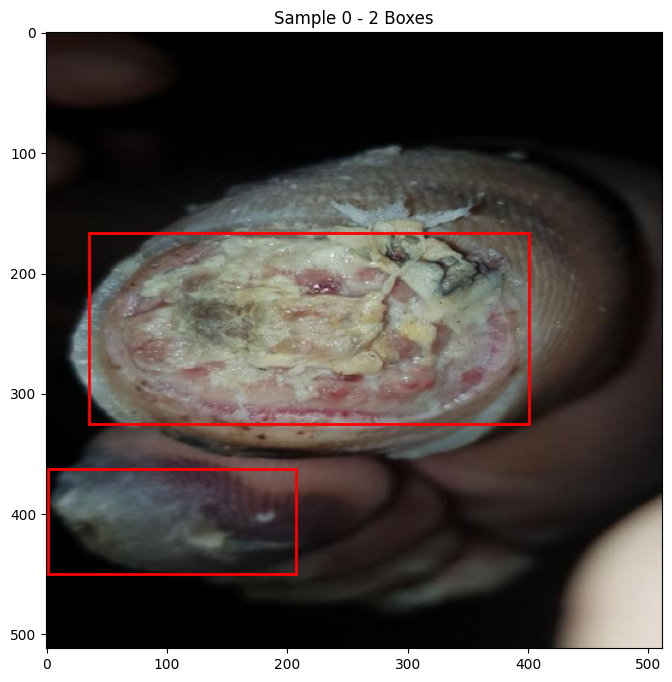

In [62]:
# Define function to visualize dataset samples
def visualize_sample(dataset, idx):
    img, target = dataset[idx]

    # Convert tensor image to NumPy array (if needed)
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

    # Denormalize (if necessary)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img * std + mean).clip(0, 1)  # Reverse normalization

    # Create plot
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)

    # Draw bounding boxes
    for box in target["boxes"]:
        x1, y1, x2, y2 = box.tolist()  # Convert tensor to list
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.set_title(f"Sample {idx} - {len(target['boxes'])} Boxes")
    plt.show()

# Test visualization on the training dataset
visualize_sample(train_dataset, idx=0)  # Change idx to see different images


## Model Development

### Hyperparameter Optimization

In [54]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.4 MB/s eta 0:00:00


In [63]:
import torch
import torchvision
import optuna
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.optim import AdamW, SGD
import numpy as np

# Define function to load Faster R-CNN model
def get_faster_rcnn(num_classes, backbone="resnet50"):
    # weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Modify the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Define training function
def train_model(model, train_loader, optimizer, device, epochs=3):
    model.train()

    for epoch in range(epochs):
        for images, targets in train_loader:
            # Filter out images without any bounding boxes
            filtered_images = []
            filtered_targets = []

            for img, tgt in zip(images, targets):
                if tgt["boxes"].numel() > 0:  # Ensure at least one bbox exists
                    filtered_images.append(img)
                    filtered_targets.append(tgt)

            if len(filtered_images) == 0:
                continue  # Skip batch if all images have no bounding boxes

            # Move tensors to device
            filtered_images = [img.to(device) for img in filtered_images]
            filtered_targets = [{k: v.to(device) for k, v in t.items()} for t in filtered_targets]

            # Compute loss
            loss_dict = model(filtered_images, filtered_targets)
            loss = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model


# Define evaluation function (Compute mAP)
def evaluate_model(model, valid_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in valid_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i in range(len(images)):
                all_predictions.append(outputs[i]["boxes"].cpu().numpy())
                all_targets.append(targets[i]["boxes"].cpu().numpy())

    # Compute mean IoU (proxy for mAP)
    iou_scores = []
    for pred_boxes, gt_boxes in zip(all_predictions, all_targets):
        if len(pred_boxes) == 0 or len(gt_boxes) == 0:
            continue
        iou_scores.append(np.mean([np.max([iou(pred, gt) for gt in gt_boxes]) for pred in pred_boxes]))

    return np.mean(iou_scores) if iou_scores else 0.0

# IoU Calculation
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return interArea / float(boxAArea + boxBArea - interArea)

# Define objective function for Optuna
def objective(trial):
    # Sample hyperparameters
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [2, 4, 8])
    epochs = trial.suggest_int("epochs", 3, 10)

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_faster_rcnn(num_classes=2).to(device)

    # Select optimizer
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train model
    train_model(model, train_loader, optimizer, device, epochs=epochs)

    # Evaluate model
    mAP_score = evaluate_model(model, valid_loader, device)

    return mAP_score

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Print best hyperparameters
print("Best Hyperparameters:", study.best_params)

[I 2025-03-19 10:14:17,252] A new study created in memory with name: no-name-5d87302a-d899-48b5-a8d1-2aa11eac80a7
<ipython-input-63-276b69ac0308>:94: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
<ipython-input-63-276b69ac0308>:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
[I 2025-03-19 10:18:32,079] Trial 0 finished with value: 0.0 and parameters: {'lr': 0.00927121308272491, 'weight_decay': 0.00033194003800574164, 'batch_size': 2, 'epochs': 4}. Best is trial 0 with value: 0.0.
[I 2025-03-19 10:27:36,598] Trial 1 finished with value: 0.3893193861189984

Best Hyperparameters: {'lr': 4.846061590870594e-05, 'weight_decay': 6.131156459283831e-05, 'batch_size': 8, 'epochs': 10}


In [ ]:
# Best Hyperparameters: {'lr': 4.846061590870594e-05, 'weight_decay': 6.131156459283831e-05, 'batch_size': 8, 'epochs': 10}

### Training

In [66]:
# Extract best hyperparameters
best_params = study.best_params

# Load Faster R-CNN with 2 classes (ulcer vs. background)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_faster_rcnn(num_classes=2).to(device)

# Use AdamW optimizer with best LR & weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])

# Train model for best epoch count
train_model(model, train_loader, optimizer, device, epochs=best_params["epochs"])

# Save trained model
torch.save(model.state_dict(), "faster_rcnn_ulcer_best.pth")
print("✅ Final model training complete! Saved model.")

✅ Final model training complete! Saved model.


### Evaluation

In [67]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load Faster R-CNN with 2 classes (background + ulcer)
def load_trained_model(model_path, num_classes=2):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

    # Modify the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Load trained weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    return model

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_trained_model("faster_rcnn_ulcer_best.pth").to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


In [68]:
import numpy as np

def evaluate_model(model, valid_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in valid_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i in range(len(images)):
                all_predictions.append(outputs[i]["boxes"].cpu().numpy())
                all_targets.append(targets[i]["boxes"].cpu().numpy())

    # Compute mean IoU (proxy for mAP)
    iou_scores = []
    for pred_boxes, gt_boxes in zip(all_predictions, all_targets):
        if len(pred_boxes) == 0 or len(gt_boxes) == 0:
            continue
        iou_scores.append(np.mean([np.max([iou(pred, gt) for gt in gt_boxes]) for pred in pred_boxes]))

    return np.mean(iou_scores) if iou_scores else 0.0

# IoU Calculation
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return interArea / float(boxAArea + boxBArea - interArea)

# Compute mAP Score
mAP_score = evaluate_model(model, valid_loader, device)
print(f"✅ Model mAP Score: {mAP_score:.4f}")


✅ Model mAP Score: 0.3820


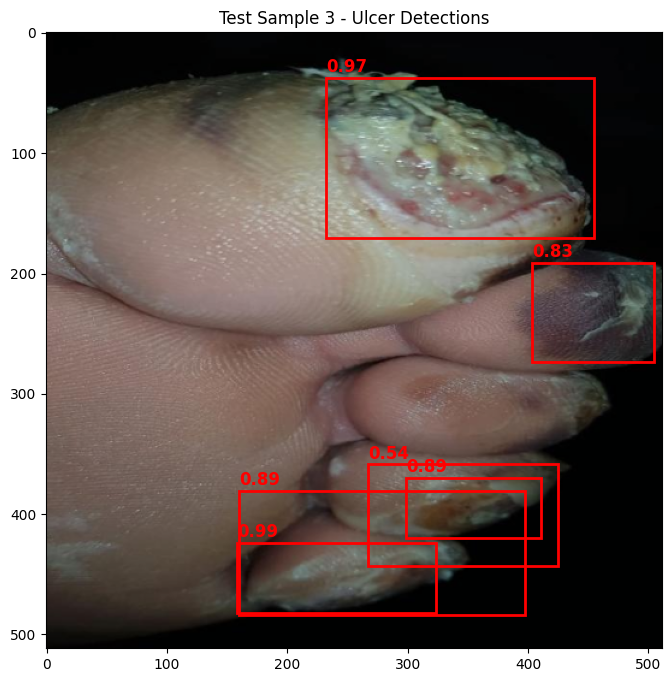

In [72]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(model, dataset, idx, device):
    model.eval()

    # Load image & target
    img, _ = dataset[idx]
    img_tensor = img.to(device).unsqueeze(0)  # Add batch dimension

    # Get predictions
    with torch.no_grad():
        output = model(img_tensor)[0]  # Extract first image result

    # Convert image to NumPy (denormalize)
    img = img.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img * std + mean).clip(0, 1)

    # Create plot
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)

    # Draw detected boxes
    for box, score in zip(output["boxes"], output["scores"]):
        if score > 0.5:  # Confidence threshold
            x1, y1, x2, y2 = box.cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"{score:.2f}", color="red", fontsize=12, weight="bold")

    ax.set_title(f"Test Sample {idx} - Ulcer Detections")
    plt.show()

# Test visualization on the test dataset

visualize_predictions(model, test_dataset, idx=3, device=device)  # Change idx to view different samples
